In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [70]:
import urllib2
import datetime

import numpy  as np

from astropy import units as u
from astropy.coordinates import SkyCoord, AltAz, EarthLocation
from astropy.time import Time
from astropy.utils.data import get_readable_fileobj
from astropy.io import fits
from astropy.table import Table

In [160]:
for module in ['hosts', 'targeting', 'aat']:
    if module in globals():
        reload(globals()[module])
    else:
        globals()[module] = __import__(module)
#g = targeting.get_gama() #re-caches the gama catalog

In [161]:
hsd = hosts.get_saga_hosts_from_google(clientsecretjsonorfn='client_secrets.json', useobservingsummary=False)
hsd = dict([(h.name, h) for h in hsd])

Using cached version of google hosts list from file "hosts_dl.pkl"


# Initial planning steps 

In [62]:
ufo = urllib2.urlopen('https://docs.google.com/spreadsheet/ccc?key=1b3k2eyFjHFDtmHce1xi6JKuj3ATOWYduTBFftx5oPp8&output=csv')
hosttab = QTable.read(ufo.read(), format='csv')
ufo.close()
hostscs = SkyCoord(u.Quantity(hosttab['RA'], u.deg), 
                   u.Quantity(hosttab['Dec'], u.deg), 
                   distance=u.Quantity(hosttab['distance'], u.Mpc))

In [57]:
#UTC time from 8:35-19:35 is AAT 18 deg window
nighttimes = Time('2015-6-20 8:35:00') + np.arange(12)*u.hour
aao = EarthLocation(lon='149:3:57.9', lat='-31:16:37.3')
aao_frame = AltAz(obstime=nighttimes, location=aao)

In [85]:
seczs = []
for sc in hostscs:
    az = sc.transform_to(aao_frame)
    seczs.append(az.secz)
seczs = np.array(seczs)

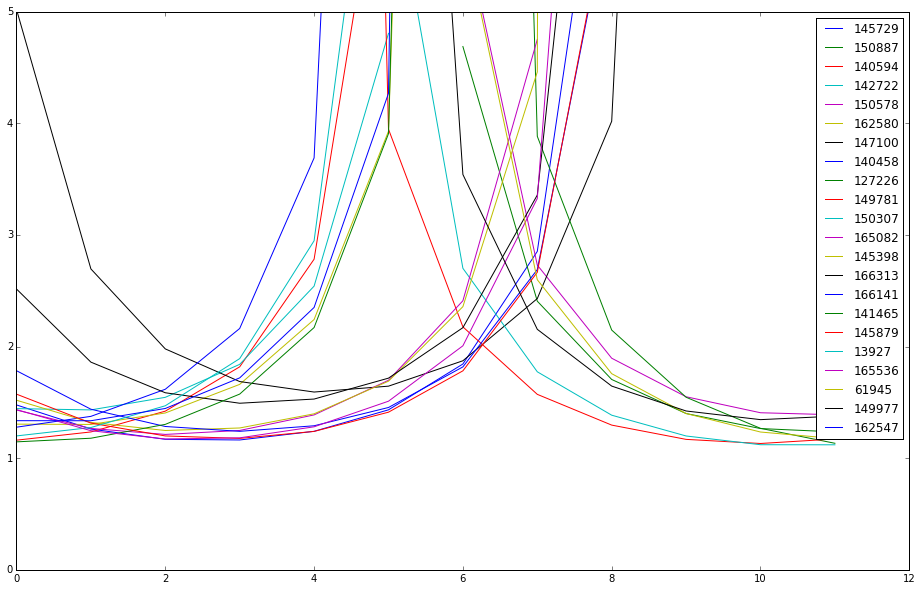

In [128]:
hrsvis = np.sum((1<=seczs)&(seczs<1.75),axis=1)

visenough = hrsvis>2
for secz, nsaid in zip(seczs[visenough], hosttab['NSAID'][visenough]):
    msk = secz>0
    plt.plot(np.arange(len(secz))[msk], secz[msk], label=nsaid)
plt.legend(loc=0)
plt.ylim(0,5)

In [137]:
names = []
ras = []

with open('aat_targets/aattargs_iobserve.dat', 'w') as f:
    for host in hosttab[visenough]:
        name = 'NSA'+str(host['NSAID'])
        for nm, val in hsd.items():
            if val.nsaid == host['NSAID']:
                name = nm
                if nm.startswith('NSA'):
                    name = name+'_obsed'
                break
        f.write(name.replace(' ','_') + ' ')
        f.write(str(host['RA']) + ' ')
        f.write(str(host['Dec']) + '\n')
        
        names.append(name)
        ras.append(host['RA'])
    
names = np.array(names)
ras = np.array(ras)
earlymsk = (10<ras/15)&(ras/15<18)
print('Early targets')
for nm in names[earlymsk]:
    print(nm)
    
print('\nLater targets')
for nm in names[~earlymsk]:
    print(nm)
    

Early targets
NSA145729
Alice in Wonderland
NSA142722
NSA162580
Odyssey
NSA140458
NSA165082
NSA145398
Gilgamesh
NSA166141
NSA141465
NSA145879
Sopronos
Dune
NSA162547

Later targets
NSA150887
NSA150578
NSA127226
NSA149781
NSA150307
Ana Karenina
NSA149977


# Actual targeting 

Plan: Dune/Ody/Gilg, Aeneid, OBrother, Anak

In [155]:
dune = hsd['Dune']
ody = hsd['Odyssey']
gilg = hsd['Gilgamesh']
aen = hsd['Aeneid']
aen.environsarcmin = 30.
ob = hsd['OBrother']
anak = hsd['AnaK']
hostsforrun = [dune, ody, gilg, aen, ob, anak]

In [104]:
[(h.name, h.environskpc, h.environsarcmin) for h in hostsforrun]

[('Dune', 300.0, 41.056090595371984),
 ('Odyssey', 300.0, 30.327438140711887),
 ('Gilgamesh', 300.00000000000006, 37.18825214427636),
 ('Aeneid', 452.7927606385165, 30.0),
 ('OBrother', 300.0, 26.544825520097508),
 ('AnaK', 300.0, 29.934639294505377)]

In [139]:
for h in hostsforrun:
    print(h.name, h.fnsdss)
    print(h.sdss_environs_query(dl=False, xmatchwise=True, usecas=True))
    print('\n\n')

('Dune', 'catalogs/Dune_sdss.dat')

SELECT  p.objId  as objID,
p.ra, p.dec, p.type, p.flags, p.specObjID, dbo.fPhotoTypeN(p.type) as phot_sg,
p.modelMag_u as u, p.modelMag_g as g, p.modelMag_r as r,p.modelMag_i as i,p.modelMag_z as z,
p.modelMagErr_u as u_err, p.modelMagErr_g as g_err, p.modelMagErr_r as r_err,p.modelMagErr_i as i_err,p.modelMagErr_z as z_err,
p.psfMag_u as psf_u, p.psfMag_g as psf_g, p.psfMag_r as psf_r, p.psfMag_i as psf_i, p.psfMag_z as psf_z,
p.fibermag_r, p.fiber2mag_r,
p.petroMag_r + 2.5*log10(2*PI()*p.petroR50_r*p.petroR50_r) as sb_petro_r,
p.expMag_r, p.expMag_r + 2.5*log10(2*PI()*p.expRad_r*p.expRad_r + 1e-20) as sb_exp_r,
p.deVMag_r, p.deVMag_r + 2.5*log10(2*PI()*p.deVRad_r*p.deVRad_r + 1e-20) as sb_deV_r,
p.lnLExp_r, p.lnLDeV_r, p.lnLStar_r,
p.extinction_u as Au, p.extinction_g as Ag, p.extinction_r as Ar, p.extinction_i as Ai, p.extinction_z as Az,
ISNULL(s.z, -1) as spec_z, ISNULL(s.zErr, -1) as spec_z_err, ISNULL(s.zWarning, -1) as spec_z_warn, s.class as

In [153]:
#make sure the catalogs are downloaded/cached
for h in hostsforrun:
    print(h.name)
    h.usnob_environs_query(True)
    h.sdss_environs_query(dl=True, xmatchwise=True)  # turns out this fails so have to fall back on CasJobs above
    
#Note: Had to custom-download Dune and AnaK USNOB because too big

Dune
File catalogs/Dune_usnob.dat exists - not downloading anything.
File catalogs/Dune_sdss.dat exists - not downloading anything.
Odyssey
File catalogs/Odyssey_usnob.dat exists - not downloading anything.
File catalogs/Odyssey_sdss.dat exists - not downloading anything.
Gilgamesh
File catalogs/Gilgamesh_usnob.dat exists - not downloading anything.
File catalogs/Gilgamesh_sdss.dat exists - not downloading anything.
Aeneid
File catalogs/Aeneid_usnob.dat exists - not downloading anything.
File catalogs/Aeneid_sdss.dat exists - not downloading anything.
OBrother
File catalogs/OBrother_usnob.dat exists - not downloading anything.
File catalogs/OBrother_sdss.dat exists - not downloading anything.
AnaK
File catalogs/AnaK_usnob.dat exists - not downloading anything.
File catalogs/AnaK_sdss.dat exists - not downloading anything.


In [154]:
for h in hostsforrun:
    c = h.get_sdss_catalog()
    csc = SkyCoord(ra=c['ra']*u.deg, dec=c['dec']*u.deg, distance=h.dist)
    hsc = SkyCoord(h.coords, distance=h.dist)
    print(h.name,'max',np.max(csc.separation_3d(hsc).to(u.kpc)))

KeyboardInterrupt: 

Latest cuts:
```
rlim=20.5  or 21

   qsaga = where(sdss.r le rlim and sdss.rhost_kpc le 300 and
sdss.remove eq -1 and $
              sdss.g-sdss.r-2*sdss.g_err-2*sdss.r_err le 0.8 and $
              sdss.r-sdss.i-2*sdss.r_err-2*sdss.i_err le 0.5 and $
              sdss.r-sdss.K-2*sdss.r_err-2*sdss.Kerr le 2.0 and $
              sdss.r-sdss.W1-2*sdss.r_err-2*sdss.W1err le 2.6 and $
              sdss.u-sdss.g+2*sdss.u_err+2*sdss.g_err gt $
                         1.5*(sdss.g-sdss.r-2*sdss.g_err-2*sdss.r_err)-0.2 and $
              sdss.sb_exp_r ge 0.42*sdss.r+13.2 and $
              sdss.fibermag_r le 23,nsaga)


   qgri = where(sdss.r le rlim and sdss.rhost_kpc le 300 and $
              sdss.g-sdss.r-2*sdss.g_err-2*sdss.r_err le 0.8 and $
              sdss.r-sdss.i-2*sdss.r_err-2*sdss.i_err le 0.5 and $
              sdss.fibermag_r le 23,ngri)
```

In [188]:
colorcuts = {'g-r': (None, 0.8, 2),
             'r-i': (None, 0.5, 2),
             'r-K': (None, 2.0, 2),
             'r-w1': (None, 2.6, 2)}
def uggrline_cut(cat, sl=1.5, inter=-0.2):
    gt = cat['u']-cat['g']+2*(cat['u_err']+cat['g_err'])
    lt = sl*(cat['g']-cat['r']-2*(cat['g_err']+cat['r_err'])) + inter
    return gt > lt

In [189]:
allgoodspec = Table(fits.getdata('allgoodspec_v2_jun14_15.fits.gz'))
allgoodspecnorem = allgoodspec[allgoodspec['REMOVE']!=-1]

Notes on allgoodspec fields:
```
    #      SATS = 3   if object is SAGA PRIMARY HOST
    #      SATS = 2   if object is low-z, z < 0.05
    #      SATS = 1   if object is SAGA SATELLITE (+/- 200 km/s w/in 300kpc)
    #      SATS = 0   if object is high-z, z > 0.05
    #      SATS = -1  no redshift


#  REMOVE =  -1 = GOOD OBJECT
#  REMOVE =   1 =  ON REMOVE LIST, DO NOT USE  (rm_removelist_obj)
#  REMOVE =   2 = SHREDDED OBJECT BASED ON NSA (nsa_cleanup)
# REMOVE =    3 = REPEATED SPECTRUM
```

In [192]:
c = ob.get_sdss_catalog()
reload(targeting)
res=targeting.select_targets(ob, colorcuts=colorcuts, morecuts=[uggrline_cut])
len(res)

Removing 61 objects at high z w/ good spectra, keeping 0 (total of 16770 objects)
('morecuts removed', 9, 'objects')


573